In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from Bio import SeqIO
from sklearn.preprocessing import normalize
from tqdm.notebook import tqdm

In [2]:
project_dir = "C:\\Users\\tilenkopac\\Projects\\genome-embedding"
data_dir = os.path.join(project_dir, "data", "deepmicrobes_mock_communities")
models_dir = os.path.join(project_dir, "models")
autoencoder_name = "661k_conv_small_elu_loc_pres_ld10_ws100_take_2"
sampler_name = "no-sampler"

In [3]:
# models
autoencoder = tf.keras.models.load_model(os.path.join(models_dir, "autoencoders", autoencoder_name))
encoder = autoencoder.encoder
classifiers = [
    # tf.keras.models.load_model(os.path.join(models_dir, "classifiers", autoencoder_name, sampler_name,
    #                                         "mag-reads-genus-classifier-4-layers-32-units-inverse-class-weights")),
    tf.keras.models.load_model(os.path.join(models_dir, "classifiers", autoencoder_name, sampler_name,
                                            "mag-reads-genus-classifier-4-layers-32-units"))
]
print(f"Classifier output size: {classifiers[0].layers[0].layers[-1].output.shape[-1]}")

# data
mag_reads_data_dir = os.path.join(project_dir, "data", "deepmicrobes_mag_reads")
with open(os.path.join(mag_reads_data_dir, "taxa_index.pkl"), "rb") as file:
    taxa_index = pickle.load(file)

Classifier output size: 46


In [4]:
organism_taxa = {}
with open(os.path.join(data_dir, "community_supplementary_data.csv"), "rt") as file:
    file.readline()
    file.readline()
    for line in file:
        fields = line.split(";")
        org_id = fields[0]
        org_taxon = taxa_index["genus"].get(fields[2], -1)
        organism_taxa[org_id] = org_taxon

In [5]:
nuc_onehot_enc = {
    "A": [1.0, 0.0, 0.0, 0.0],
    "G": [0.0, 1.0, 0.0, 0.0],
    "C": [0.0, 0.0, 1.0, 0.0],
    "T": [0.0, 0.0, 0.0, 1.0],
    "N": [0.0, 0.0, 0.0, 0.0]}


def preprocess_seq(seq):
    # cut sequence to correct length
    seq = seq[:100]

    # one-hot encode nucleotides
    encoded = [nuc_onehot_enc[nuc] for nuc in seq]

    return encoded

In [6]:
n_reads = 10000000
reads_preprocessed = []
labels = []
unknown_taxa_count = 0
with open(os.path.join(data_dir, "mock_metagenome_01.1.fq"), "rt") as file:
    reads = SeqIO.parse(file, "fastq")
    for j, read in tqdm(enumerate(reads), total=n_reads):
        if len(read) >= 100:
            org_taxon = organism_taxa[read.id.split(".")[0]]
            if org_taxon != -1:
                # organism's taxon is in the set of taxa known by the classifier
                reads_preprocessed.append(preprocess_seq(read.seq))
                labels.append(org_taxon)
            else:
                # organism's taxon is not known by the classifier
                unknown_taxa_count += 1

        # if i == 100000:
        #     break

  0%|          | 0/10000000 [00:00<?, ?it/s]

In [7]:
unknown_taxa_count / n_reads

0.1404781

In [8]:
predictions_probs = [[] for _ in range(len(classifiers))]
predictions_argmax = [[] for _ in range(len(classifiers))]
for i, classifier_preds in enumerate(predictions_argmax):
    for j in tqdm(range(0, len(reads_preprocessed), 4096)):
        embeddings = encoder(tf.constant(reads_preprocessed[j:j + 4096]))
        preds = classifiers[i](embeddings).numpy()
        predictions_probs[i].extend(preds)
        predictions_argmax[i].extend(np.argmax(preds, axis=-1))

  0%|          | 0/2035 [00:00<?, ?it/s]

In [17]:
predictions_probs_np = np.array(predictions_probs[0])

In [20]:
with open("C:\\Users\\tilenkopac\\temp\\predictions_probs_np", "wb") as file:
    np.save(file, predictions_probs_np)

In [6]:
with open("C:\\Users\\tilenkopac\\temp\\predictions_probs_np", "rb") as file:
    predictions_probs_np = np.load(file)

In [18]:
predictions_probs_np.shape

(8333794, 46)

In [11]:
predictions_probs_np[:100]

array([[0.01997014, 0.02065679, 0.02338091, ..., 0.0200972 , 0.02277684,
        0.02257076],
       [0.02036211, 0.02073316, 0.0232102 , ..., 0.02049966, 0.02295708,
        0.02215344],
       [0.01999841, 0.0210191 , 0.02294571, ..., 0.02045932, 0.0231623 ,
        0.0221479 ],
       ...,
       [0.01996648, 0.02090226, 0.02372651, ..., 0.0203789 , 0.02235877,
        0.02247052],
       [0.01931448, 0.02153048, 0.02274141, ..., 0.02072337, 0.02185859,
        0.02233364],
       [0.02034052, 0.02059617, 0.02338698, ..., 0.02029111, 0.02357286,
        0.02222082]], dtype=float32)

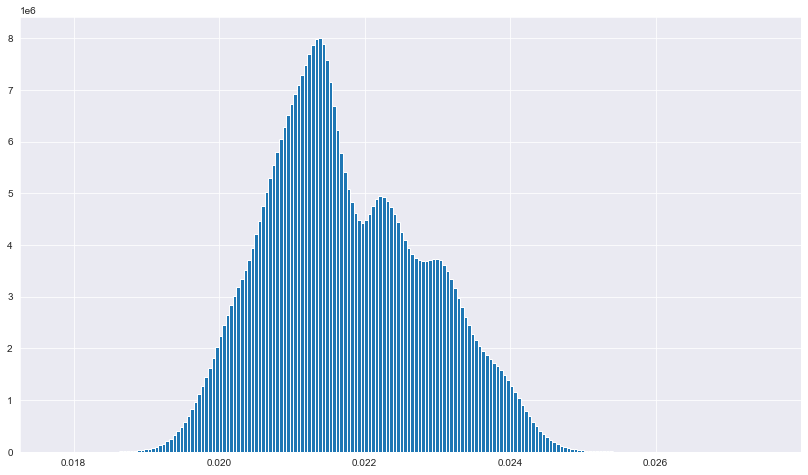

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(14, 8))
plt.hist(predictions_probs_np.flatten(), bins=200);

In [15]:
conf_mats = []
conf_mats_norm_rows = []
for i, preds in enumerate(predictions_argmax):
    conf_mat = tf.math.confusion_matrix(labels[:len(predictions_argmax[i])], predictions_argmax[i]).numpy()
    conf_mats.append(conf_mat)
    conf_mats_norm_rows.append(normalize(conf_mat, axis=1, norm="l1"))

In [ ]:
tf.math.confusion_matrix(labels[:len(predictions_argmax[0])], predictions_argmax[0])

In [ ]:
# todo: nauči model brez uteži razredov (2-krat, da preverimo vpliv stohastičnih procesov)
# todo: plot verjetnosti napovedi (namesto argmax-a)
# todo: iste confusion matrix-e izračunaj še na validacijski množici MAG-ov
# todo: preizkusi "inverzno" uteževanje (total / count)

Precision: 0.0014441201690370555


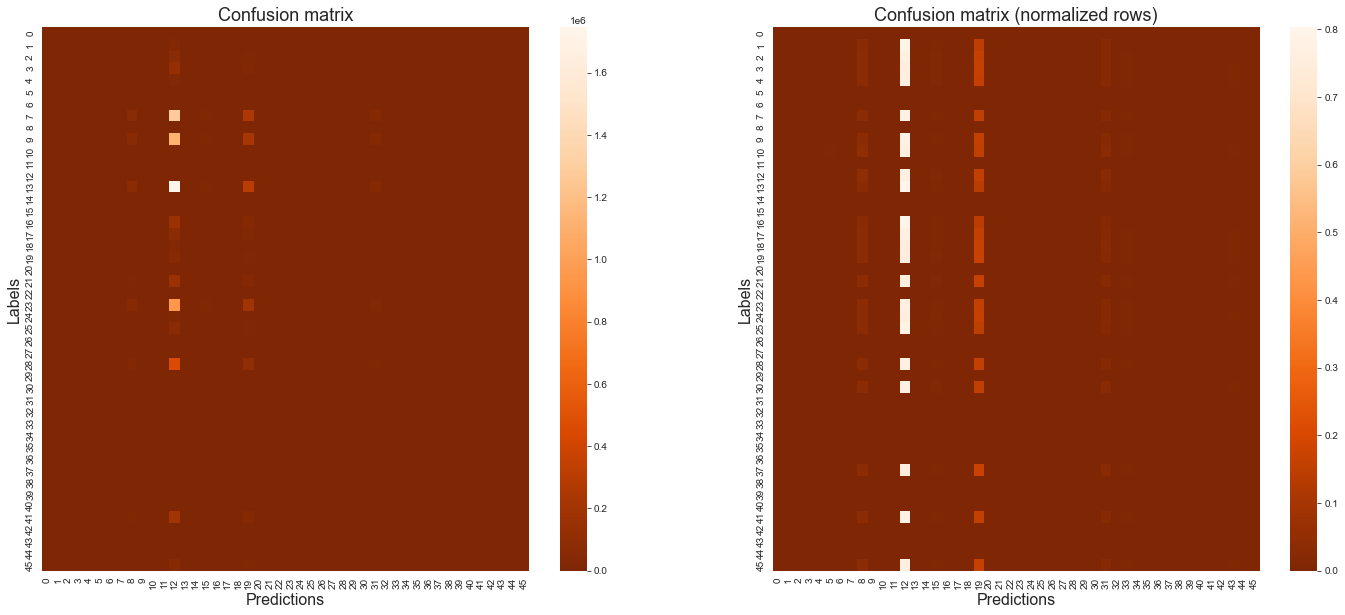

In [10]:
print(f"Precision: {sum(conf_mat.diagonal()) / sum(conf_mat.flatten())}")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
sns.heatmap(conf_mat, ax=ax1, cmap='Oranges_r')
ax1.set_xlabel("Predictions", fontsize=16)
ax1.set_ylabel("Labels", fontsize=16)
ax1.set_title("Confusion matrix", fontsize=18)

sns.heatmap(conf_mat_norm_rows, ax=ax2, cmap='Oranges_r')
ax2.set_xlabel("Predictions", fontsize=16)
ax2.set_ylabel("Labels", fontsize=16)
ax2.set_title("Confusion matrix (normalized rows)", fontsize=18);

Precision: 0.04713939413429226


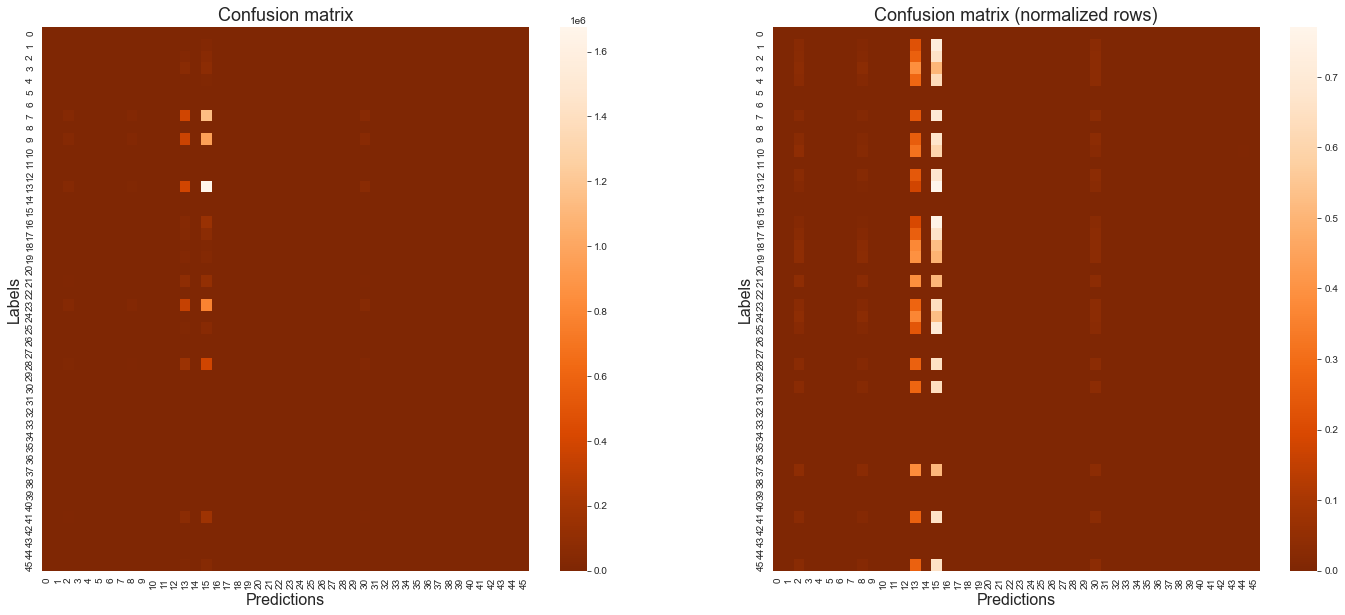

In [11]:
print(f"Precision: {sum(conf_mat2.diagonal()) / sum(conf_mat2.flatten())}")

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
sns.heatmap(conf_mat2, ax=ax1, cmap='Oranges_r')
ax1.set_xlabel("Predictions", fontsize=16)
ax1.set_ylabel("Labels", fontsize=16)
ax1.set_title("Confusion matrix", fontsize=18)

sns.heatmap(conf_mat_norm_rows2, ax=ax2, cmap='Oranges_r')
ax2.set_xlabel("Predictions", fontsize=16)
ax2.set_ylabel("Labels", fontsize=16)
ax2.set_title("Confusion matrix (normalized rows)", fontsize=18);